In [ ]:
################################################################
# Scirpt_Name: PRISM_Bulk_Download.py                          #
# Purpose(s): 1. Looping through all daily seperated fiel      #
#                and concatenate them into one single file for #
#                a each of the single year                     #
#                daily precipitation files at localr           # 
################################################################
# Written by Lujun Zhang @ U of Oklahoma 03/28/2020            #
# REVISION HISTORY                                             #
# 20200322 -- Initial section one completed by Lujun @ OU      #
# 20200328 -- Minor Modification by Lujun @ OU                 #
################################################################
# Requie packages: Numpy, Pandas, necCDF4                      #
################################################################

In [1]:
import numpy as np
import numpy.ma as ma
import pandas as pd
from datetime import timedelta
import sys
import os
import time
import datetime
from netCDF4 import Dataset  
from osgeo import gdal, ogr
import matplotlib.pyplot as plt
import matplotlib as mpl 
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import interp
from multiprocessing import Pool
from ftplib import FTP
import gdal

In [18]:
def ReadBilFile(bil):
    import gdal
    gdal.GetDriverByName('EHdr').Register()
    img = gdal.Open(bil)
    geotransform = img.GetGeoTransform()
    band = img.GetRasterBand(1)
    data = band.ReadAsArray()

    return data, geotransform

In [20]:
data_tab=ReadBilFile('F:/PRISM_Daily_Precipitation/Raw/PRISM_ppt_stable_4kmD2_20010101_bil.bil')

In [16]:
img = gdal.Open('F:/PRISM_Daily_Precipitation/Raw/PRISM_ppt_stable_4kmD2_20010101_bil.bil')
geotransform = img.GetGeoTransform()
originX = geotransform[0]
pixelWidth = geotransform[1]
originY = geotransform[3]
pixelHeight = geotransform[5]
band = img.GetRasterBand(1)
data = band.ReadAsArray()

Lon = sorted(np.arange(originX,originX+pixelWidth*(np.shape(data)[1]-0.001),pixelWidth)+360)
Lat = sorted(np.arange(originY+pixelHeight*(np.shape(data)[0]),originY,-pixelHeight))

C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app
C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()


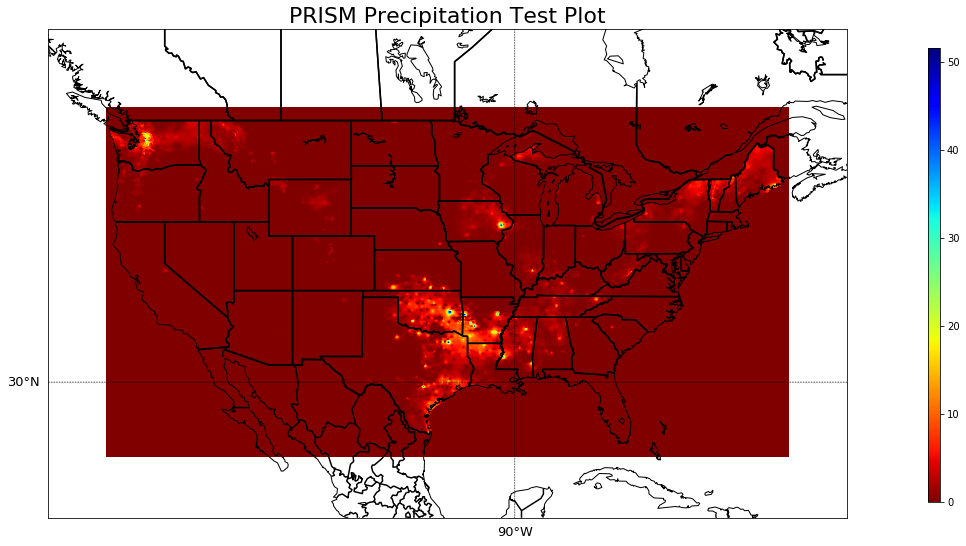

In [17]:
Long = Lon
Lat = Lat
Prec = np.flip(data,axis=0)

lon_min=np.min(Long)-5; lon_max=np.max(Long)+5
lat_min=np.min(Lat)-5; lat_max=np.max(Lat)+5

plt.figure(figsize=(16,9))
plt.title('PRISM Precipitation Test Plot',fontsize=22)
m=Basemap(projection='mill',llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution='l')

lon,lat=np.meshgrid(Long,Lat)
lon,lat=m(lon,lat)
m.drawcoastlines(linewidth=1)
m.drawstates(linewidth=1.5)
m.drawcountries(linewidth=2)
m.drawparallels(np.arange(-90, 90,30), labels=[1,0,0,0], fontsize=13,linewidth=0.8)
m.drawmeridians(np.arange(-180, 180, 45), labels=[0,0,0,1], fontsize=13,linewidth=0.8)
cmap = plt.cm.jet_r
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Prec))
#norm = mpl.colors.Normalize(vmin=0, vmax=0.01)
cf = plt.pcolormesh(lon,lat,Prec,cmap=cmap,norm=norm)
#cax = ax[1].pcolor(lon,lat,Prec[450,0,3],camp=camp)
cax=plt.axes([0.93, 0.15, 0.01,0.7])
cbar = plt.colorbar(cf,cax=cax)

In [73]:
year_range = range(2019,2020)
for i in year_range:
    ## 
    # Tell if its a leap year(365 days or 366 days)
    if (i%400==0)or(i%4==0 and i%100!=0):
        j_range = 366
    else:
        j_range = 365
    # Creating dates for later str stiching
    date = pd.date_range(start=(str(i)+'/01/01'), end=(str(i)+'/12/31'), freq="d")
    ##
    # Looping within each year "i" daily PRISM precipitation data
    for j in range(j_range):
            date_tab = pd.to_datetime(date[j]).strftime('%Y%m%d')
            if (i==2019 and j>242):
                bil = r'/vsizip/F:\PRISM_Daily_Precipitation\Raw\PRISM_ppt_provisional_4kmD2_{0}_bil.zip\PRISM_ppt_provisional_4kmD2_{0}_bil.bil'.format(date_tab)
            else:
                bil = r'/vsizip/F:\PRISM_Daily_Precipitation\Raw\PRISM_ppt_stable_4kmD2_{0}_bil.zip\PRISM_ppt_stable_4kmD2_{0}_bil.bil'.format(date_tab)       
            data_tab, geotransform = ReadBilFile(bil)
            data_tab = np.flip(data_tab,axis=0)
            data_tab = np.expand_dims(data_tab,0)
            if (j==0):
                ##
                # Reading & Saving GeoReference
                originX = geotransform[0]
                pixelWidth = geotransform[1]
                originY = geotransform[3]
                pixelHeight = geotransform[5]
                Lon = sorted(np.arange(originX,originX+pixelWidth*(np.shape(data_tab)[2]-0.001),pixelWidth)+360)
                Lat = sorted(np.arange(originY+pixelHeight*(np.shape(data_tab)[1]),originY,-pixelHeight))
                ##
                # Creating "Data" to concatenate all PRISM data in one matrix
                Data = data_tab
                print('Start orgnazing year '+str(i)+' PRISM data')
            elif (j==range(j_range)[-1]):
                Data = np.concatenate((Data,data_tab),axis=0) 
                print('Data-set shape '+str(np.shape(Data)))
                ## 
                # Save concatenated PRISM dataset at local disk
                Out_Direc = 'F:/PRISM_Daily_Precipitation/Organized/PRISM_'+str(i)+'_Daily_Precipitation.nc'
                ncOutput = Dataset(Out_Direc, 'w', format='NETCDF4')
                ncOutput.createDimension('Lon', np.size(Lon))
                ncOutput.createDimension('Lat', np.size(Lat))
                ncOutput.createDimension('T', np.shape(Data)[0])
                ##
                # Add lat Variable
                var_out_Y = ncOutput.createVariable('Lat','f',("Lat"))
                ncOutput.variables['Lat'][:] = Lat[:]
                ##
                # Add lon Variable
                var_out_X = ncOutput.createVariable('Lon','f',("Lon"))
                ncOutput.variables['Lon'][:] = Lon[:]
                ##
                # Add time Variable
                var_out_S = ncOutput.createVariable('T','f',("T"))
                ncOutput.variables['T'][:] = np.arange(np.shape(Data)[0])[:]
                ##
                # Add data Variable
                var_out_data = ncOutput.createVariable('Prec', 'f',("T","Lat","Lon"))
                ncOutput.variables['Prec'][:,:,:] = Data[:,:,:]
                ##
                # attr
                ncOutput.history = "Created datatime " + datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S") + " by LujunZ at OU"
                ncOutput.source  = "netCDF4 under python 3.6.5"
                ncOutput.close()  # close the new file  
                
                print('year '+str(i)+' PRISM data re-organized!')    
            else:
                Data = np.concatenate((Data,data_tab),axis=0) 

Start orgnazing year 2019 PRISM data
Data-set shape (365, 621, 1405)
year 2019 PRISM data re-organized!


In [ ]:
PRISM_ppt_provisional_4kmD2_20190901_bil.bil

In [71]:
bil

'/vsizip/F:\\PRISM_Daily_Precipitation\\Raw\\PRISM_ppt_provisional_4kmD2_20190901_bil.zip\\PRISM_ppt_provisonal_4kmD2_20190901_bil.bil'

C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  app.launch_new_instance()
C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:21: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
C:\Users\zhan0101\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:22: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


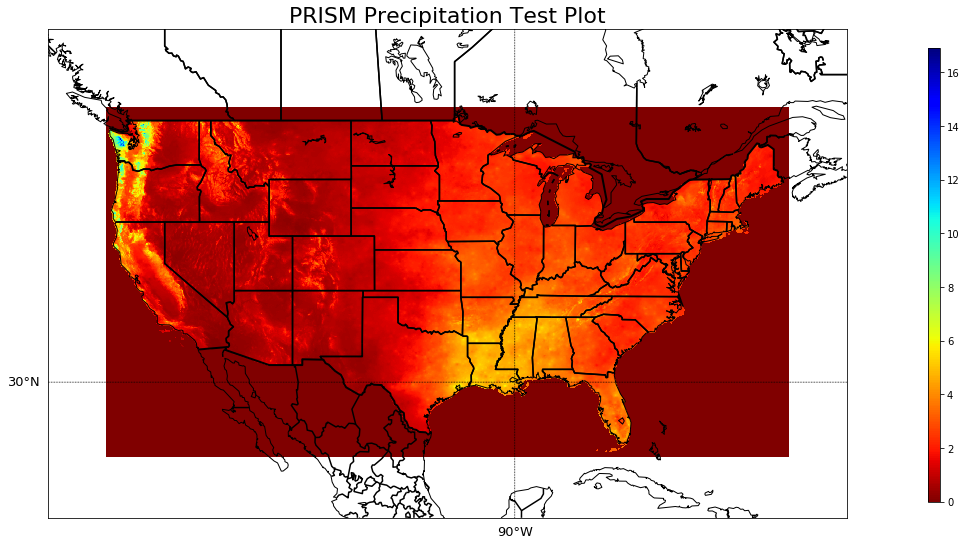

In [57]:
Data_test = Dataset('PRISM_2001_Daily_Precipitation.nc')
Lon = Data_test['Lon'][:]
Lat = Data_test['Lat'][:]
Precip = Data_test['Prec'][:]
Precip = np.mean(Precip,axis=0)

Long = Lon
Lat = Lat
Prec = Precip

lon_min=np.min(Long)-5; lon_max=np.max(Long)+5
lat_min=np.min(Lat)-5; lat_max=np.max(Lat)+5

plt.figure(figsize=(16,9))
plt.title('PRISM Precipitation Test Plot',fontsize=22)
m=Basemap(projection='mill',llcrnrlon=lon_min,urcrnrlon=lon_max,llcrnrlat=lat_min,urcrnrlat=lat_max,resolution='l')

lon,lat=np.meshgrid(Long,Lat)
lon,lat=m(lon,lat)
m.drawcoastlines(linewidth=1)
m.drawstates(linewidth=1.5)
m.drawcountries(linewidth=2)
m.drawparallels(np.arange(-90, 90,30), labels=[1,0,0,0], fontsize=13,linewidth=0.8)
m.drawmeridians(np.arange(-180, 180, 45), labels=[0,0,0,1], fontsize=13,linewidth=0.8)
cmap = plt.cm.jet_r
norm = mpl.colors.Normalize(vmin=0, vmax=np.max(Prec))
#norm = mpl.colors.Normalize(vmin=0, vmax=0.01)
cf = plt.pcolormesh(lon,lat,Prec,cmap=cmap,norm=norm)
#cax = ax[1].pcolor(lon,lat,Prec[450,0,3],camp=camp)
cax=plt.axes([0.93, 0.15, 0.01,0.7])
cbar = plt.colorbar(cf,cax=cax)